In [1]:
from tifffile import imread
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
from pyama_core.io.nd2_loader import load_nd2

In [3]:
nd2_path = "/Volumes/SSD/250129_HuH7.nd2"
da, metadata = load_nd2(nd2_path)
times = np.array(metadata.timepoints)
times /= 3600 * 1e3

In [4]:
phc_good_path = "../data/p000c000.tif"
fluor_good_path = "../data/p000c001.tif"
phc_bubble_path = "../data/p016c000.tif"
fluor_bubble_path = "../data/p016c001.tif"

phc_good = imread(phc_good_path)
fluor_good = imread(fluor_good_path)
phc_bubble = imread(phc_bubble_path)
fluor_bubble = imread(fluor_bubble_path)

In [5]:
phc_good.shape, phc_good.dtype, phc_good.nbytes/1e9

((181, 2044, 2048), dtype('uint16'), 1.515372544)

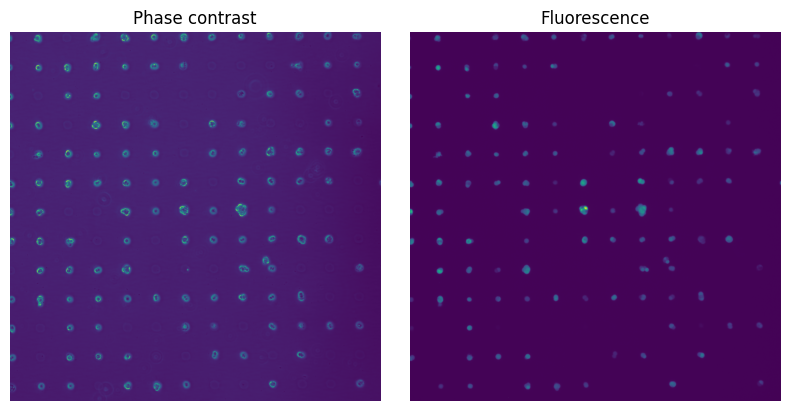

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)
axs[0].imshow(phc_good[100])
axs[0].set_title('Phase contrast')
axs[1].imshow(fluor_good[100])
axs[1].set_title('Fluorescence')

axs[0].axis('off')
axs[1].axis('off')
fig.savefig('good.png', dpi=300)

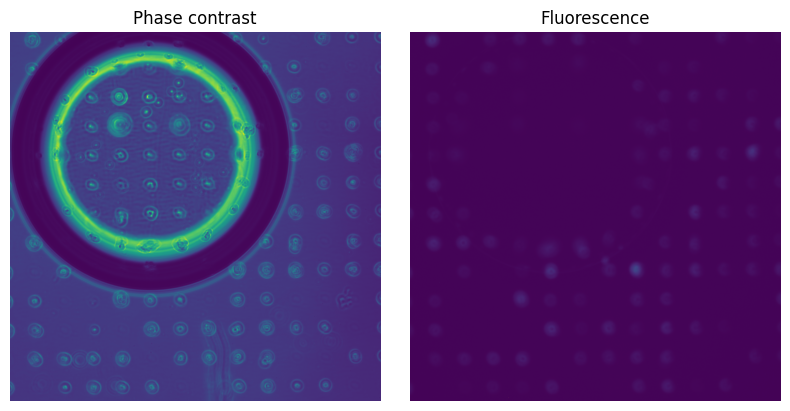

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)
axs[0].imshow(phc_bubble[100])
axs[0].set_title('Phase contrast')
axs[1].imshow(fluor_bubble[100])
axs[1].set_title('Fluorescence')

axs[0].axis('off')
axs[1].axis('off')
fig.savefig('bubble.png', dpi=300)

In [8]:
def progress_callback(current, total, message):
    if current % 30 == 0:
        print(f"{message}: {current}/{total}")

In [9]:
from pyama_core.processing.segmentation import segment_cell

In [10]:
try:
    seg_good = np.load("seg_good.npy")
except FileNotFoundError:
    seg_good = np.empty_like(phc_good, dtype=bool)
    segment_cell(phc_good, seg_good, progress_callback)
    np.save("seg_good.npy", seg_good)

In [11]:
seg_good.shape, seg_good.dtype, seg_good.nbytes/1e9

((181, 2044, 2048), dtype('bool'), 0.757686272)

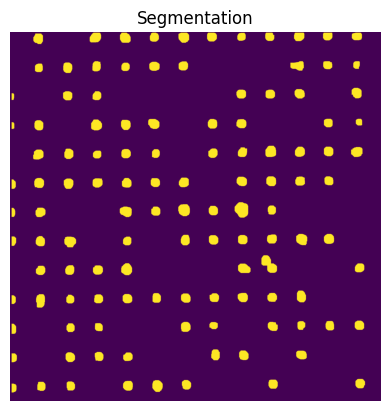

In [12]:
fig, axs = plt.subplots(1, 1, figsize=(4, 4), constrained_layout=True)
axs.imshow(seg_good[100])
axs.set_title('Segmentation')
axs.axis('off')
fig.savefig('seg_good.png', dpi=300)

In [13]:
from pyama_core.processing.background import correct_bg

In [14]:
try:
    corrected_good = np.load("corrected_good.npy")
except FileNotFoundError:
    corrected_good = np.empty_like(fluor_good, dtype=np.float32)
    correct_bg(fluor_good, seg_good, corrected_good, progress_callback)
    np.save("corrected_good.npy", corrected_good)

In [15]:
corrected_good.shape, corrected_good.dtype, corrected_good.nbytes/1e9

((181, 2044, 2048), dtype('float32'), 3.030745088)

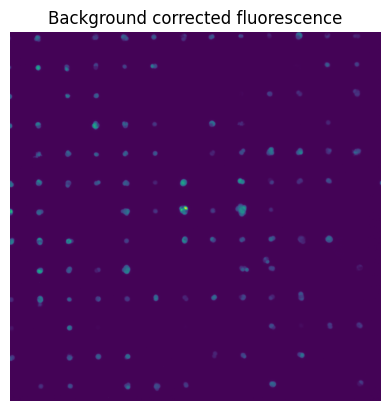

In [16]:
fig, axs = plt.subplots(1, 1, figsize=(4, 4), constrained_layout=True)
axs.imshow(corrected_good[100])
axs.set_title('Background corrected fluorescence')
axs.axis('off')
fig.savefig('corrected_good.png', dpi=300)

In [17]:
from pyama_core.processing.tracking import track_cell

In [18]:
try:
    seg_good_labeled = np.load("seg_good_labeled.npy")
except FileNotFoundError:
    seg_good_labeled = np.zeros_like(seg_good, dtype=np.uint16)
    track_cell(seg_good, seg_good_labeled, progress_callback=progress_callback)

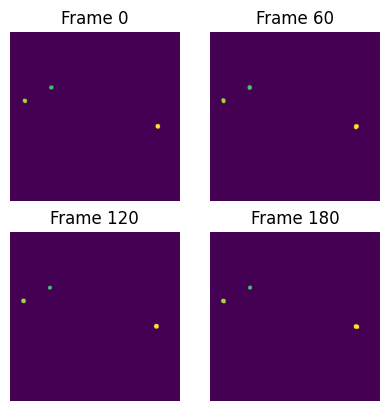

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(4, 4), constrained_layout=True)
axs = axs.ravel()
time_steps = np.linspace(0, len(seg_good_labeled)-1, 4).astype(int)
for i,t in enumerate(time_steps):
    fr = seg_good_labeled[t]
    axs[i].imshow(np.where(np.isin(fr, [50, 60, 70]), fr, 0))
    axs[i].set_title(f"Frame {t}")
    axs[i].axis('off')
fig.savefig('seg_good_labeled.png', dpi=300)

In [20]:
np.save("seg_good_labeled.npy", seg_good_labeled)

In [21]:
from pyama_core.processing.extraction import extract_trace

In [22]:
try:
    df = pd.read_csv('trace.csv', index_col=['cell', 'time'])
except FileNotFoundError:   
    df = extract_trace(corrected_good, seg_good_labeled, times, progress_callback)
    df.to_csv('trace.csv')

In [23]:
all_cells = df.index.get_level_values('cell').unique()

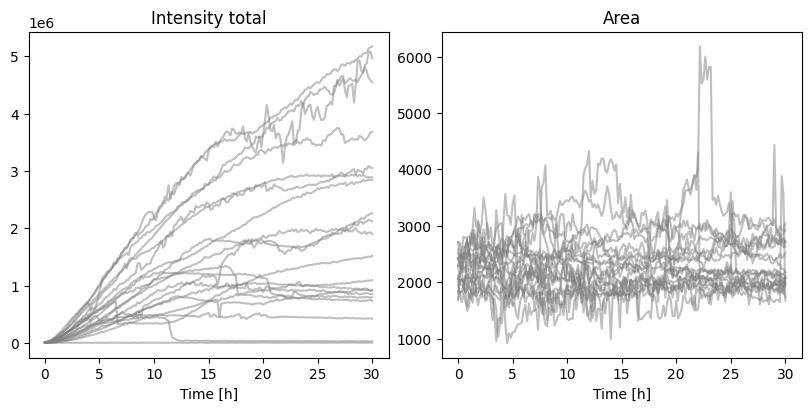

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)
for c in all_cells[:20]:
    df.loc[c].plot(y='intensity_total', ax=axs[0], legend=False, color='gray', alpha=0.5)
    df.loc[c].plot(y='area', ax=axs[1], legend=False, color='gray', alpha=0.5)
axs[0].set_title('Intensity total')
axs[1].set_title('Area')
axs[0].set_xlabel('Time [h]')
axs[1].set_xlabel('Time [h]')
fig.savefig('features.png', dpi=300)

In [25]:
from pyama_core.analysis.fitting import fit_model
from pyama_core.analysis.models import get_model

In [26]:
df2_path = '../data/HuH7_FCSnew_GFP.csv'
df2 = pd.read_csv(df2_path, index_col=0, skiprows=1, header=None)

In [33]:
y = df.loc[60]['intensity_total']
t = times
model = get_model('trivial')
result = fit_model('trivial', t, y)
r_squared = result.r_squared
params = result.fitted_params
y_pred = model.eval(t, params)

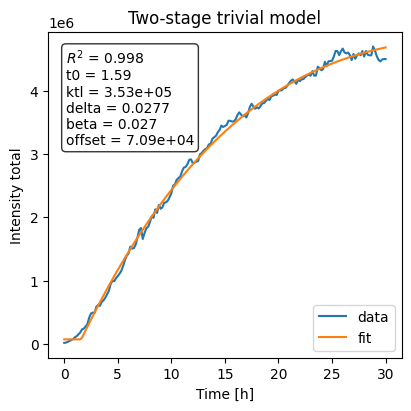

In [38]:
fig, axs = plt.subplots(1, 1, figsize=(4, 4), constrained_layout=True)
axs.plot(t, y, label='data')
axs.plot(t, y_pred, label='fit')
axs.text(
    0.05, 0.95,
    f"$R^2$ = {r_squared:.3f}\n" + "\n".join([f"{k} = {v:.3g}" for k, v in params.items()]),
    transform=axs.transAxes,
    fontsize=10,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)
axs.legend(loc='lower right')
axs.set_xlabel('Time [h]')
axs.set_ylabel('Intensity total')
axs.set_title('Two-stage trivial model')
fig.savefig('fit.png', dpi=300)